In [17]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [18]:
# path config
data_path = os.path.join(os.getcwd(), 'ml-latest-small')
movies_filename = 'movies.csv'
ratings_filename = 'ratings.csv'

# 1. Carregar dados

In [19]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [20]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 76.2+ KB


In [21]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [22]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [23]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('{} usuarios exclusivos e {} filmes exclusivos encontrados'.format(num_users, num_items))

610 usuarios exclusivos e 9724 filmes exclusivos encontrados


# 2. Analise exploratoria dos dados
    - Traçando a contagem de cada avaliçao
    - Traçando a frequencia da avaliaçao de cada filme

a. traçando a contagem de cada avaliaçao

O primeiro passo é ter as contagens de cada avaliaçao a partir dos dados de avaliaçao.

In [25]:
# obtendo contagem
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [31]:
# Há muito mais contagens na classificação de zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# Acrescentar contagens de classificação zero a df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


A contagem para pontuação de classificação zero é muito grande para comparar com outras. Então, vamos pegar a transformação de log para valores de contagem e, então, podemos plotá-los para comparar

In [32]:
# Adicionando contagem de log
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Text(0, 0.5, 'Número de avaliações')

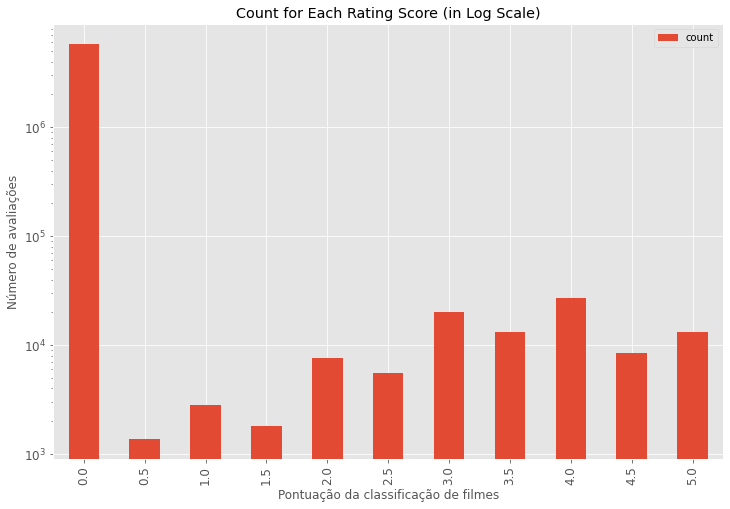

In [33]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Pontuação da classificação de filmes")
ax.set_ylabel("Número de avaliações")


<p>É interessante que há mais pessoas classificando a pontuaçao entre 3 e 4 do que outras pontuaçoes</p>

b. traçando a frequencia de classificaçao de todos os filmes

In [34]:
df_ratings.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [36]:
# Obtendo a frequencia da avaliaçao
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'number of ratings')

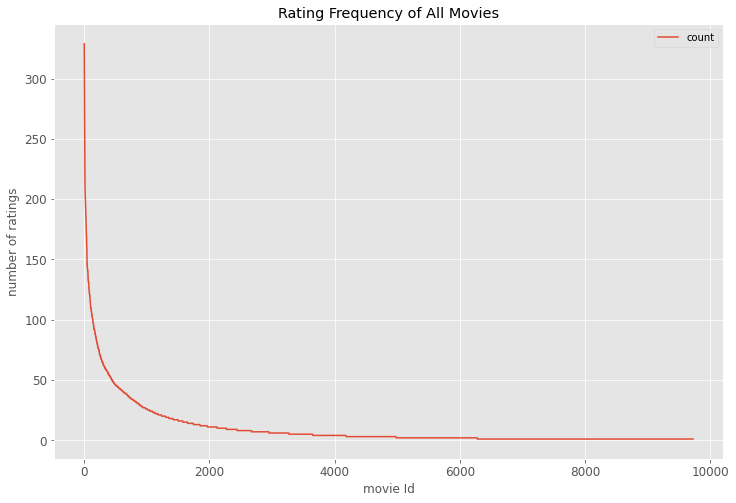

In [41]:
# traçando a frenquencia de classificaçao de todos os filmes
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

A distribuição de classificações entre os filmes geralmente satisfaz uma propriedade em configurações do mundo real, que é conhecida como propriedade de cauda longa. De acordo com essa propriedade, apenas uma pequena fração dos itens é classificada com frequência. Esses itens são chamados de itens populares. A grande maioria dos itens raramente é avaliada. Isso resulta em uma distribuição altamente distorcida das classificações subjacentes

Vamos plotar a mesma distribuição, mas com escala logarítmica

Text(0, 0.5, 'number of ratings (log scale)')

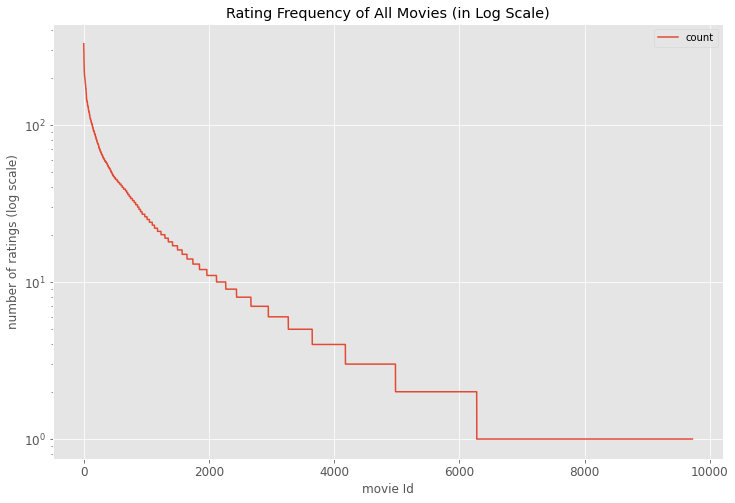

In [42]:
# traçar a frequência de classificação de todos os filmes em escala logarítmica
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [43]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

- Memory issue: we don't want to run into the “MemoryError” during model training
- Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [44]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping unpopular movies:  (41360, 3)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [46]:
# Obter o numero de avaliaçoes dado pelos usuarios
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,117
2,15
3,6
4,84
5,34


Text(0, 0.5, 'number of ratings')

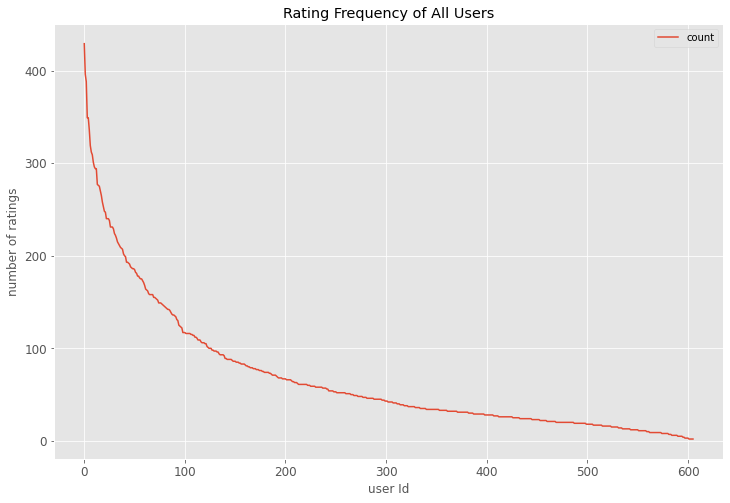

In [47]:

# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [48]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    429.00
0.95    223.50
0.90    166.00
0.85    134.25
0.80    105.00
0.75     85.00
0.70     74.00
0.65     62.25
0.60     56.00
0.55     48.00
Name: count, dtype: float64

Podemos ver que a distribuição das avaliações pelos usuários é muito semelhante à distribuição das avaliações entre os filmes. Ambos têm propriedade de cauda longa. Apenas uma pequena fração dos usuários está ativamente envolvida na classificação dos filmes que assistiram. A grande maioria dos usuários não está interessada em classificar filmes. Portanto, podemos limitar os usuários aos 40% principais

In [49]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 3)


# 3. Treinar modelo KNN para filtro colaborativo baseado em item
- Reformulando os dados
- Ajustando o modelo

### a. Reformulando os dados

Para os K vizinhos mais proximos, nos queremos que o dado seja um array (artist, user), onde cada linha é um filme e cada coluna é um usuario diferente. Para remodelar o dataframe, vamos dinamizar o dataframe para o formato largo com filmes como linhas e usuários como colunas. Em seguida, preencheremos as observações ausentes com 0s, já que realizaremos operações de álgebra linear (calculando distâncias entre vetores). Finalmente, transformamos os valores do dataframe em uma matriz esparsa scipy para cálculos mais eficientes.

In [50]:
# dinamizar e criar matriz de usuário de filme
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# criar mapeador do título do filme para o índice
movie_to_idx = {
    movie: i for i, movie in
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transformar a matriz em matriz esparsa
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

### b. Ajustando o modelo

Hora de implementar o modelo. Vamos inicializar a classe NearestNeighbors como model_knn e ajustar a matriz sparsa como a instancia. Especificando a metrica = cosine, o modelo irá medir a similaridade entre vetores do artista usando a similaridade  do cosseno

In [51]:

%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# 4. Usar o modelo treinado para fazer recomendaçoes de filmes para min mesmo.

Finalmente estamos prontos para fazer algumas recomendaçoes.

In [52]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None

    Parameters
    ----------
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [53]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.3474416136741638
2: Sherlock Holmes (2009), with distance of 0.34635400772094727
3: Kung Fu Panda (2008), with distance of 0.3432350754737854
4: Inception (2010), with distance of 0.3307400345802307
5: District 9 (2009), with distance of 0.31877219676971436
6: Up (2009), with distance of 0.31706738471984863
7: WALL·E (2008), with distance of 0.27033132314682007
8: Avengers, The (2012), with distance of 0.26102906465530396
9: Avatar (2009), with distance of 0.25990235805511475
10: Dark Knight, The (2008), with distance of 0.24018973112106323


É muito interessante que meu modelo KNN recomende filmes que também foram produzidos em anos muito semelhantes. No entanto, a distância cosseno de todas essas recomendações é, na verdade, muito pequena. Provavelmente, isso ocorre porque há muitos valores zero em nossa matriz de usuários de filmes. Com muitos valores zero em nossos dados, a dispersão dos dados se torna um problema real para o modelo KNN e a distância no modelo KNN começa a diminuir. Então, eu gostaria de cavar mais fundo e olhar mais de perto nossos dados.

### (Inspeção extra)
Vejamos agora como a matriz do usuário do filme é esparsa, calculando a porcentagem de valores zero nos dados.

In [55]:
# Calculando o numero total de entradas em uma matriz filme-usuario
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# Calculando o numero total de entrada com valores zero.
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calcular a proporção do número de zeros para o número de entradas
ratio_zeros = num_zeros / num_entries
print('Cerca de {:.2%} das avaliaçoes estao ausentes no banco de dados'.format(ratio_zeros))

Cerca de 72.64% das avaliaçoes estao ausentes no banco de dados


Este resultado confirma a hipótese de que grande maioria das entradas em nossos dados é zero. Isso explica por que a distância entre itens semelhantes ou opostos é muito grande.

# 5. Mergulhando no gargalo da filtragem colaborativa baseada em item

- Problema de congelamento inicial
- Problema de dispersão dos dados
- viés popular (como recomendar produtos desde o final da distribuição de produtos)
- Gargalo na scalabilidade


Vimos que aproximadademente 73% das interações do usuário com o filme ainda não foram gravadas, mesmo depois de filtrar filmes menos conhecidos e usuários inativos. Aparentemente, nem mesmo temos informações suficientes para que o sistema faça inferências confiáveis ​​para usuários ou itens. Isso é chamado de problema de Cold Start no sistema de recomendação.

1. Nova comunidade: refere-se ao início do recomendador, quando, embora possa existir um catálogo de itens, quase nenhum usuário está presente e a falta de interação do usuário torna muito difícil fornecer recomendações confiáveis
2. Novo item: um novo item é adicionado ao sistema, ele pode ter algumas informações de conteúdo, mas nenhuma interação está presente
3. Novo usuário: um novo usuário se cadastra e ainda não proporcionou nenhuma interação, portanto não é possível fornecer recomendações personalizadas

Não estamos preocupados com o último, porque podemos usar a filtragem baseada em item para fazer recomendações para novos usuários. Em nosso caso, estamos mais preocupados com os dois primeiros casos, especialmente o segundo caso.

O problema de inicialização a frio do item se refere a quando os itens adicionados ao catálogo têm nenhuma ou muito poucas interações. Isso constitui um problema principalmente para algoritmos de filtragem colaborativa, devido ao fato de que eles dependem das interações do item para fazer recomendações. Se nenhuma interação estiver disponível, um algoritmo de colaboração puro não pode recomendar o item. Caso apenas algumas interações estejam disponíveis, embora um algoritmo colaborativo seja capaz de recomendá-lo, a qualidade dessas recomendações será ruim. Surge outra questão, que não está mais relacionada a novos itens, mas sim a itens impopulares. Em alguns casos (por exemplo, recomendações de filmes), pode acontecer que um punhado de itens receba um número extremamente alto de iterações, enquanto a maioria dos itens recebe apenas uma fração delas. Isso também é conhecido como viés de popularidade. Lembre-se da distribuição enviesada de cauda longa anterior do gráfico de frequência de classificação de filmes.

Além disso, a escalabilidade também é um grande problema no modelo KNN. Sua complexidade de tempo é O (nd + kn), onde n é a cardinalidade do conjunto de treinamento ed a dimensão de cada amostra. E KNN leva mais tempo para fazer inferências do que treinar, o que aumenta a latência de predição

# 6. Estudos futuros

Usar o ALS do Spark para resolver os problemas acima
